# Step 1 : Set up llm code


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")


# Step 2: Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.When defining a graph, the first step is to define its State. The State includes the graph's schema and reducer functions that handle state updates. In our example, State is a TypedDict with one key: messages. The add_messages reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# Step 3: Define nodes Nodes represent units of work. They are typically regular python functions.

In [4]:
# Step 2: Define a tool

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from tavily import TavilyClient

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(doc_content_chars_max = 10000000))
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

# print(wikipedia.run("India"))

def wikipedia_tool(query: str)->str:
    """Goes to wikipedia and searches for the query
    Args:
        query (str): The query to search for
    Returns:
        str: The result of the search
    """
    wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(doc_content_chars_max = 10000000))
    return wikipedia.run(query)

def tavily_tool(query: str)->str:
    """Goes to tavily search and searches for the  query and gives the detailed content
    Args:
        query (str): The query to search for
    Returns:
        str: The result of the search
    """
    response = tavily_client.search(query)
    content = ""
    for i in response['results']:
        content += i['content']
    return content

llm_with_wikipedia_tool = llm.bind_tools([wikipedia_tool])

llm_with_tavily_tool = llm.bind_tools([tavily_tool])

from langchain_core.messages import SystemMessage

sys_message_wikipedia = SystemMessage(content="You are a helpful assistant that breaks down the query into a key word and searches wikipedia for the key word")
sys_message_tavily = SystemMessage(content="You are a helpful assistant that breaks down the quert into a key word and searches tavily for the key word")
#Define nodes
def wikipedia_llm(state: State):
    return {'messages': [llm_with_wikipedia_tool.invoke([sys_message_wikipedia] + state["messages"] )]}
sys_message_summarize = SystemMessage(content="You are a helpful assistant that summarizes the content given to you")
def summarize_llm(state: State):
    """Summarizes the wikipedia content"""
    return {'messages': [llm.invoke([sys_message_summarize] + state["messages"] )]}

# def tavily_llm(state: State):
#     return {'messages': [llm_with_tavily_tool.invoke([sys_message_tavily] + state["messages"] )]}


# Define Graph

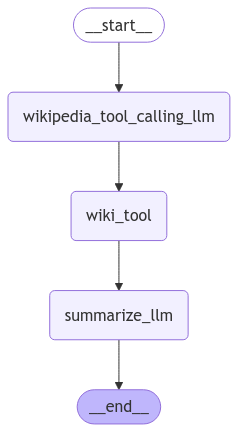

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

graph_builder = StateGraph(State)
graph_builder.add_node("wikipedia_tool_calling_llm", wikipedia_llm)
graph_builder.add_node("wiki_tool",ToolNode([wikipedia_tool]))
graph_builder.add_node("summarize_llm", summarize_llm)
# graph_builder.add_node("tavily_tool_calling_llm", tavily_llm)  
# graph_builder.add_node("tavily_tool",ToolNode([tavily_tool]))

graph_builder.add_edge(START, "wikipedia_tool_calling_llm")
# graph_builder.add_edge(START, "tavily_tool_calling_llm")
# graph_builder.add_edge("tavily_tool_calling_llm", "tavily_tool")
graph_builder.add_edge("wikipedia_tool_calling_llm", "wiki_tool")

graph_builder.add_edge("wiki_tool", "summarize_llm")
# graph_builder.add_edge("tavily_tool", "summarize_llm")
graph_builder.add_edge("summarize_llm", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

# Check the graph

In [6]:
from langchain_core.messages import HumanMessage
messages = graph.invoke({"messages": [HumanMessage(content="Indian Food")]})

In [70]:
messages


{'messages': [HumanMessage(content='Indian Food', additional_kwargs={}, response_metadata={}, id='238d1a95-f1d9-4a0c-a454-86eb71ae2965'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia_tool', 'arguments': '{"query": "Indian Food"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-4c008d6e-2f22-4905-8e9d-af86ed549e5f-0', tool_calls=[{'name': 'wikipedia_tool', 'args': {'query': 'Indian Food'}, 'id': '59bd8423-76e3-4ce1-8138-1c6bccba4f0c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 91, 'output_tokens': 6, 'total_tokens': 97, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="Page: Indian cuisine\nSummary: Indian cuisine consists of a variety of regional and traditional cuisines native to the Indian subcontinent. Given the diversity in soil, climate, culture, ethnic groups, and occupations, these cuisines vary substantially and use locally 

In [7]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Indian Food
================================== Ai Message ==================================
Tool Calls:
  wikipedia_tool (aaa5f538-612b-41da-b040-cef49ed5605a)
 Call ID: aaa5f538-612b-41da-b040-cef49ed5605a
  Args:
    query: Indian Food
================================= Tool Message =================================
Name: wikipedia_tool

Page: Indian cuisine
Summary: Indian cuisine consists of a variety of regional and traditional cuisines native to the Indian subcontinent. Given the diversity in soil, climate, culture, ethnic groups, and occupations, these cuisines vary substantially and use locally available spices, herbs, vegetables, and fruits.
Indian food is also heavily influenced by religion, in particular Hinduism and Islam, cultural choices and traditions. Historical events such as invasions, trade relations, and colonialism have played a role in introducing certain foods to India. The Columbia